In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib


In [3]:
df = pd.read_csv('/content/workload_data.csv')
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (200, 4)


,workload_type,traffic_level,budget,recommended_instance
0,Batch Job,Low,High,t3.micro
1,Database,High,Low,m5.large
2,Batch Job,Medium,High,t3.medium
3,ML Training,High,Medium,m5.large
4,ML Training,Low,High,m5.large



--- Value Counts ---
workload_type
Media Server    50
ML Training     45
Web App         41
Database        34
Batch Job       30
Name: count, dtype: int64
traffic_level
Low       70
High      66
Medium    64
Name: count, dtype: int64
budget
Low       75
High      65
Medium    60
Name: count, dtype: int64
recommended_instance
t3.medium      65
t3.micro       63
m5.large       50
t2.micro        6
g4dn.xlarge     4
c5n.4xlarge     4
p3.2xlarge      3
c5.2xlarge      2
r5.large        2
t3.small        1
Name: count, dtype: int64


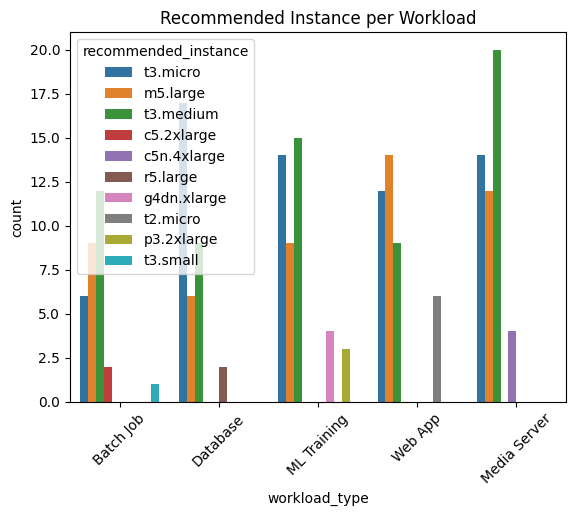

In [4]:
print("\n--- Value Counts ---")
print(df['workload_type'].value_counts())
print(df['traffic_level'].value_counts())
print(df['budget'].value_counts())
print(df['recommended_instance'].value_counts())

sns.countplot(data=df, x='workload_type', hue='recommended_instance')
plt.title('Recommended Instance per Workload')
plt.xticks(rotation=45)
plt.show()


In [5]:
X = df[['workload_type', 'traffic_level', 'budget']]
y = df['recommended_instance']

# One-hot encode categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X).toarray()
feature_names = encoder.get_feature_names_out(X.columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)

# Save encoder for future use
joblib.dump(encoder, 'encoder.joblib')


['encoder.joblib']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y, test_size=0.2, random_state=42)


In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'aws_recommender_model.joblib')

['aws_recommender_model.joblib']

In [8]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7
              precision    recall  f1-score   support

  c5.2xlarge       1.00      1.00      1.00         1
    m5.large       0.62      0.71      0.67         7
  p3.2xlarge       1.00      1.00      1.00         2
    r5.large       1.00      1.00      1.00         1
    t2.micro       1.00      1.00      1.00         2
   t3.medium       0.67      0.57      0.62        14
    t3.micro       0.64      0.69      0.67        13

    accuracy                           0.70        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.70      0.70      0.70        40



In [9]:
def rule_based_fallback(workload_type, traffic_level, budget):
    rule_map = {
        ('Web App', 'Low', 'Low'): 't2.micro',
        ('Web App', 'Medium', 'Medium'): 't3.medium',
        ('Web App', 'High', 'High'): 'm5.large',
        ('ML Training', 'High', 'High'): 'p3.2xlarge',
        ('ML Training', 'Medium', 'Medium'): 'g4dn.xlarge',
        ('Database', 'High', 'High'): 'r5.large',
        ('Database', 'Low', 'Low'): 't3.micro',
        ('Batch Job', 'Low', 'Low'): 't3.small',
        ('Batch Job', 'High', 'High'): 'c5.2xlarge',
        ('Media Server', 'High', 'High'): 'c5n.4xlarge',
    }
    return rule_map.get((workload_type, traffic_level, budget), 't3.medium')  # default fallback

# 🔍 Example usage
example = rule_based_fallback('Web App', 'Low', 'Low')
print("Rule-based recommendation:", example)


Rule-based recommendation: t2.micro
